storage scheme: 'file'
readouts: total 512, image data 512
first readout is image data
Flags [64]
Ky/PE - encoding [0]
Slices [0]
Repetitions [0]
Physiology time stamps [(0, 0, 0)]
input data dimensions: 512x8x512
total number of slices: 2
readouts per slice: 256
cloned data dimensions: 512x8x512
---
 pre-processing acquisition data...
processed data dimensions: 512x8x256
Close Figures' 1 - 3 windows to continue...


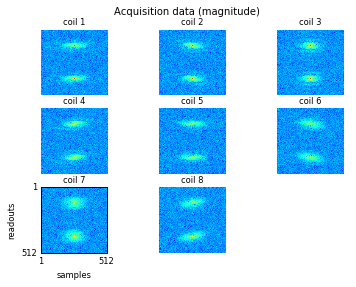

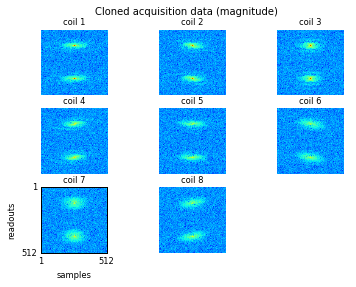

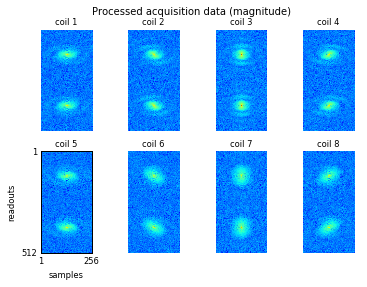

0

In [3]:
#'''
#Upper-level interface demo that illustrates how MR data can be interfaced 
#from python.
#
#Usage:
#  acquisition_data.py [--help | options]
#
#Options:
#  -f <file>, --file=<file>    raw data file
#                              [default: simulated_MR_2D_cartesian.h5]
#  -p <path>, --path=<path>    path to data files, defaults to data/examples/MR
#                              subfolder of SIRF root folder
#  -r <rnge>, --range=<rnge>   range of readouts to examine as string '(a,b)'
#                             [default: '(0,1)'] CHANGED FOR JUPYTER
#  -s <slcs>, --slices=<slcs>  max number of slices to display [default: 8]
#  -e <engn>, --engine=<engn>  reconstruction engine [default: Gadgetron]
#'''
#
## CCP PETMR Synergistic Image Reconstruction Framework (SIRF).
## Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC.
## Copyright 2015 - 2017 University College London.
## Copyright 2015 - 2017 Physikalisch-Technische Bundesanstalt.
##
## This is software developed for the Collaborative Computational
## Project in Positron Emission Tomography and Magnetic Resonance imaging
## (http://www.ccppetmr.ac.uk/).
##
## Licensed under the Apache License, Version 2.0 (the "License");
##   you may not use this file except in compliance with the License.
##   You may obtain a copy of the License at
##       http://www.apache.org/licenses/LICENSE-2.0
##   Unless required by applicable law or agreed to in writing, software
##   distributed under the License is distributed on an "AS IS" BASIS,
##   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
##   See the License for the specific language governing permissions and
##   limitations under the License.

__version__ = '0.1.0'
from docopt import docopt

from ast import literal_eval

# import engine module
#exec('from p' + args['--engine'] + ' import *')

from pGadgetron import *

# process command-line options
data_file = 'simulated_MR_2D_cartesian.h5'
data_path = petmr_data_path('mr')
    
ro_range = literal_eval('(0,1)')
slcs = 8

scheme = AcquisitionData.get_storage_scheme()
print('storage scheme: %s' % repr(scheme))



# locate the input data file
input_file = existing_filepath(data_path, data_file)

# acquisition data will be read from an HDF file input_file
acq_data = AcquisitionData(input_file)

# the raw k-space data is a list of different readouts
# of different data type (e.g. noise correlation data, navigator data,
# image data,...);
# the number of all readouts is
na = acq_data.number_of_readouts('all')
# the number of image data readouts is
ni = acq_data.number_of_readouts()
print('readouts: total %d, image data %d' % (na, ni))

# sort acquisition data;
# currently performed with respect to (in this order):
#    - repetition
#    - slice
#    - kspace encode step 1
acq_data.sort()

# retrieve the range of readouts to examine
if ro_range[0] >= ro_range[1] or ro_range[1] >= na:
    raise error('Wrong readouts range')
where = range(ro_range[0], ro_range[1])

# retrieve readouts flags
flags = acq_data.get_info('flags')

# inspect the first readout flag
if flags[0] & IMAGE_DATA_MASK:
    print('first readout is image data')
else:
    # should see this if input data file is test_2D_2x.h5
    print('first readout is not image data')
        
# display flags
print('Flags'),
print(flags[where])
    
# inspect some kspace_encode_step_1 counters
encode_step_1 = acq_data.get_info('kspace_encode_step_1')
print('Ky/PE - encoding'),
print(encode_step_1[where])
    
# inspect some slice counters
slice = acq_data.get_info('slice')
print('Slices'),
print(slice[where])
    
# inspect some repetition counters
repetition = acq_data.get_info('repetition')
print('Repetitions'),
print(repetition[where])

# inspect some physiology time stamps
pts = acq_data.get_info('physiology_time_stamp')
print('Physiology time stamps'),
print(pts[where])

# copy raw data into python array and determine its size
# in the case of the provided dataset 'simulated_MR_2D_cartesian.h5' the 
# size is 2x256 phase encoding, 8 receiver coils and points 512 readout 
# points (frequency encoding dimension)acq_array = acq_data.as_array()
acq_array = acq_data.as_array()
acq_shape = acq_array.shape
print('input data dimensions: %dx%dx%d' % acq_shape)

# cap the number of readouts to display
ns = (slice[ni - 1] + 1)*(repetition[ni - 1] + 1)
print('total number of slices: %d' % ns)
nr = ni//ns
print('readouts per slice: %d' % nr)
if ns > slcs:
    print('too many slices, showing %d only' % slcs)
    ny = slcs*nr # display this many only
else:
    ny = ni # display all

acq_array = numpy.transpose(acq_array,(1,0,2))
acq_array = acq_array[:,:ny,:]
title = 'Acquisition data (magnitude)'
show_3D_array(acq_array, power = 0.2, suptitle = title, label = 'coil', \
                xlabel = 'samples', ylabel = 'readouts', \
                show = False)
#                cmap = 'gray', show = False)

cloned_acq_data = acq_data.clone()
cloned_acq_array = cloned_acq_data.as_array()
cloned_acq_shape = cloned_acq_array.shape
print('cloned data dimensions: %dx%dx%d' % cloned_acq_shape)

cloned_acq_array = numpy.transpose(cloned_acq_array,(1,0,2))
cloned_acq_array = cloned_acq_array[:,:ny,:]
title = 'Cloned acquisition data (magnitude)'
show_3D_array(cloned_acq_array, power = 0.2, \
                suptitle = title, label = 'coil', \
                xlabel = 'samples', ylabel = 'readouts', \
                show = False)
#                cmap = 'gray', show = False)

# pre-process acquired k-space data
# Prior to image reconstruction several pre-processing steps such as 
# asymmetric echo compensation, noise decorelation for multi-coil data or 
# removal of oversampling along frequency encoding (i.e. readout or kx)
# direction. So far only the removal of readout oversampling and noise and
# asymmetric echo adjusting is implemented
print('---\n pre-processing acquisition data...')
processed_acq_data = preprocess_acquisition_data(acq_data)

# copy processed acquisition data into an array and determine its size
# by removing the oversampling factor of 2 along the readout direction, the
# number of readout samples was halfed
processed_acq_array = processed_acq_data.as_array()
processed_acq_shape = processed_acq_array.shape
print('processed data dimensions: %dx%dx%d' % processed_acq_shape)

processed_acq_array = numpy.transpose(processed_acq_array,(1,0,2))
processed_acq_array = processed_acq_array[:,:ny,:]
title = 'Processed acquisition data (magnitude)'
show_3D_array(processed_acq_array, power = 0.2, \
                suptitle = title, label = 'coil', \
                xlabel = 'samples', ylabel = 'readouts')
#                xlabel = 'samples', ylabel = 'readouts', cmap = 'gray')
